In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
sample_size = max(1, int(len(episodes) * 0.1))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 108 episodes (10.0% of 1080 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

train_loader, val_loader, train_dataset, val_dataset = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,
)

=== Dataloader Sanity Check: TRAIN ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 4 -> {'EnduroNoFrameskip-v4': 1129, 'BeamRiderNoFrameskip-v4': 159, 'MsPacmanNoFrameskip-v4': 278, 'BreakoutNoFrameskip-v4': 34}
Actions: min=0, max=8, unique=9
Rewards: min=-1.000, max=1.000
RTG: min=-13.000, max=185.000
Reward bins: unique=[0 1 2]
RTG bins: min=1, max=199
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'EnduroNoFrameskip-v4': 1129, 'BeamRiderNoFrameskip-v4': 159, 'MsPacmanNoFrameskip-v4': 278, 'BreakoutNoFrameskip-v4': 34}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': -13.0, 'rtg_max': 185.0, 'reward_bins_unique': array([0, 1, 2]), 'rt

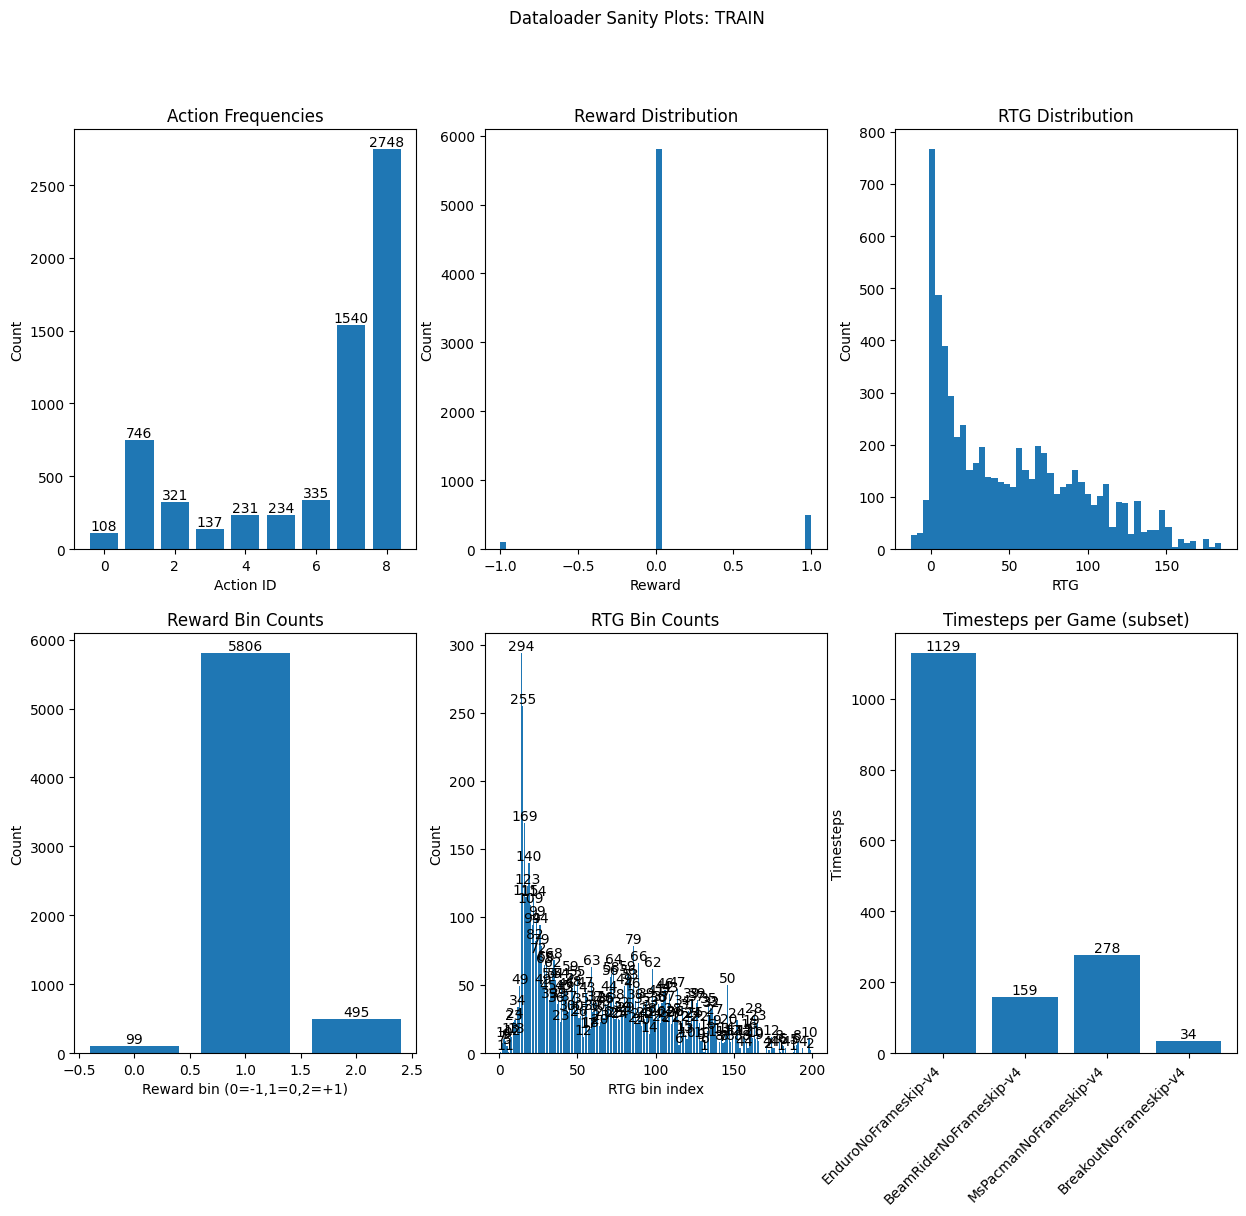

=== Dataloader Sanity Check: VAL ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 2 -> {'MsPacmanNoFrameskip-v4': 763, 'BeamRiderNoFrameskip-v4': 837}
Actions: min=0, max=8, unique=9
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=122.000
Reward bins: unique=[1 2]
RTG bins: min=14, max=136
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'MsPacmanNoFrameskip-v4': 763, 'BeamRiderNoFrameskip-v4': 837}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 122.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 14, 'rtg_bins_max': 136}


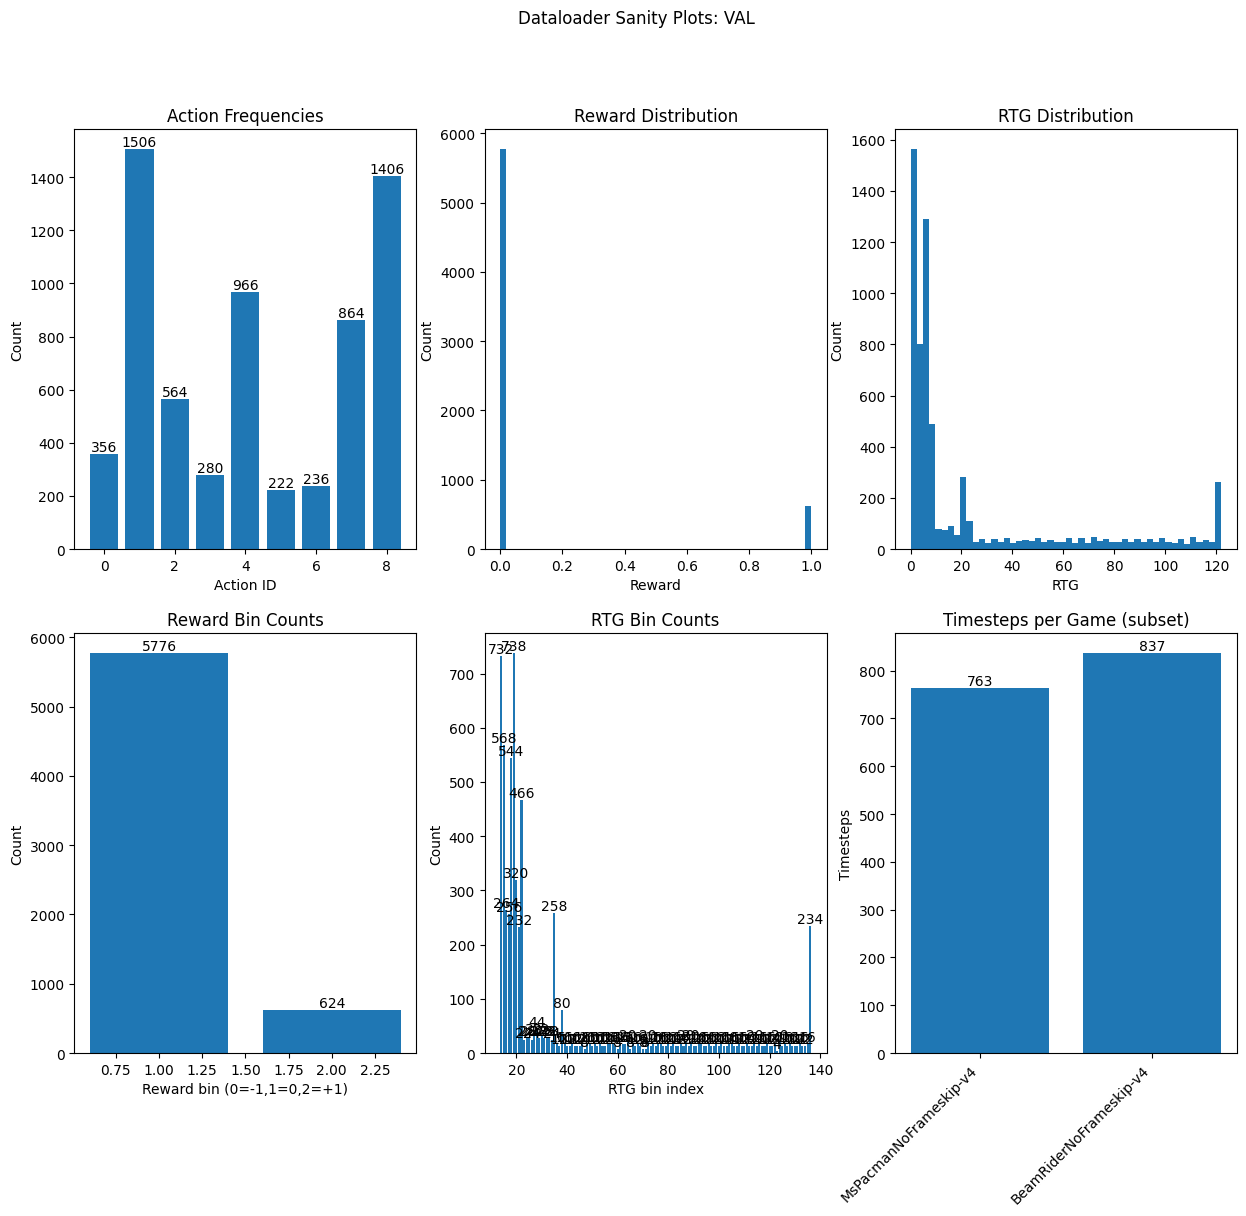

In [6]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(train_loader, "TRAIN")
inspect_dataloader(val_loader, "VAL")

# Train

In [7]:
from mgdt_model_trainer import Encoder, train_mgdt

model, train_stats, val_stats = train_mgdt(
    encoder_type=Encoder.Patch,
    episodes_train=train_dataset.episodes,
    dataset_train=train_dataset,
    dataloader_train=train_loader,
    dataloader_val=val_loader,
)

Validation: 100%|██████████| 239/239 [00:11<00:00, 21.59it/s]


# Look at Results

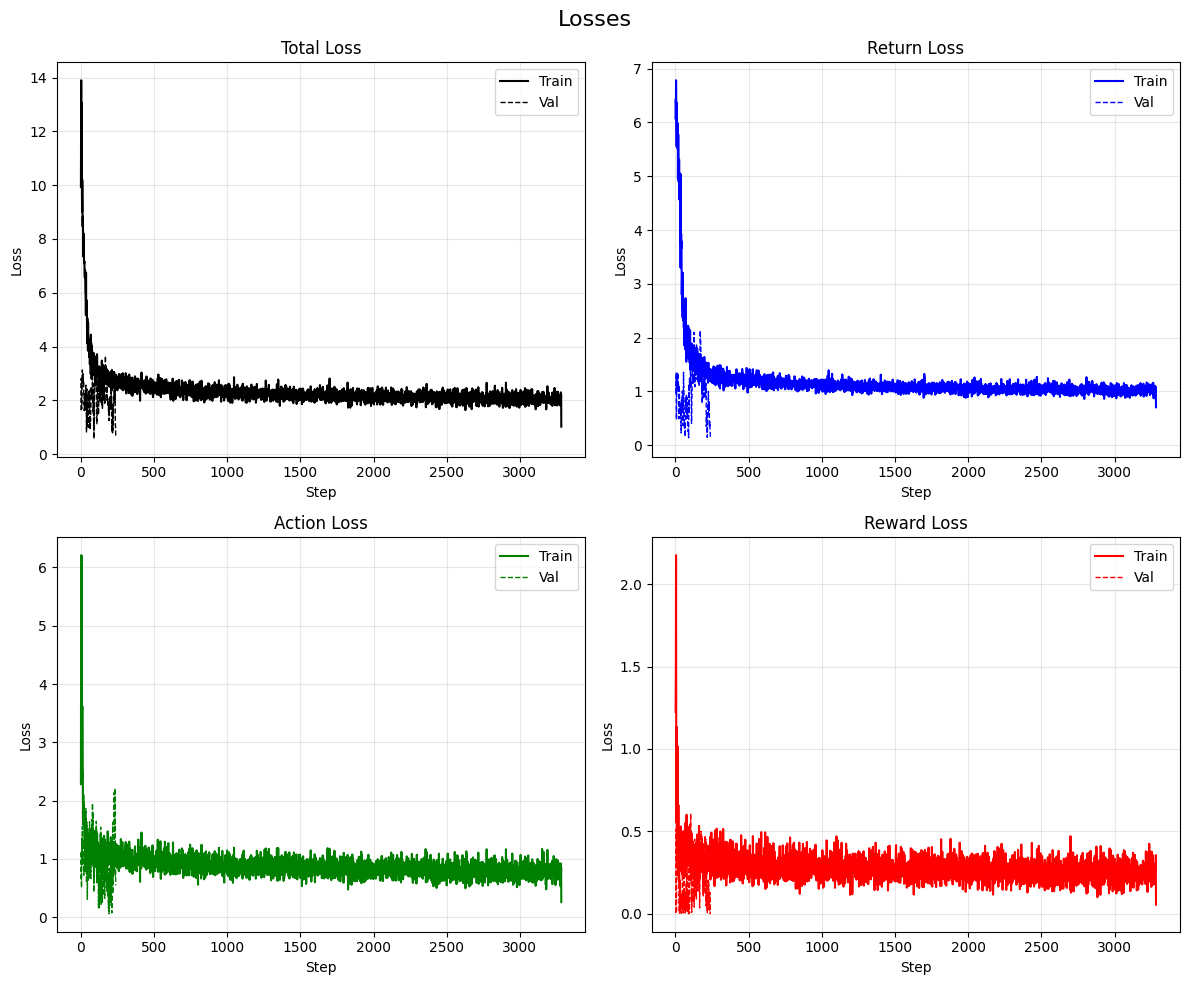

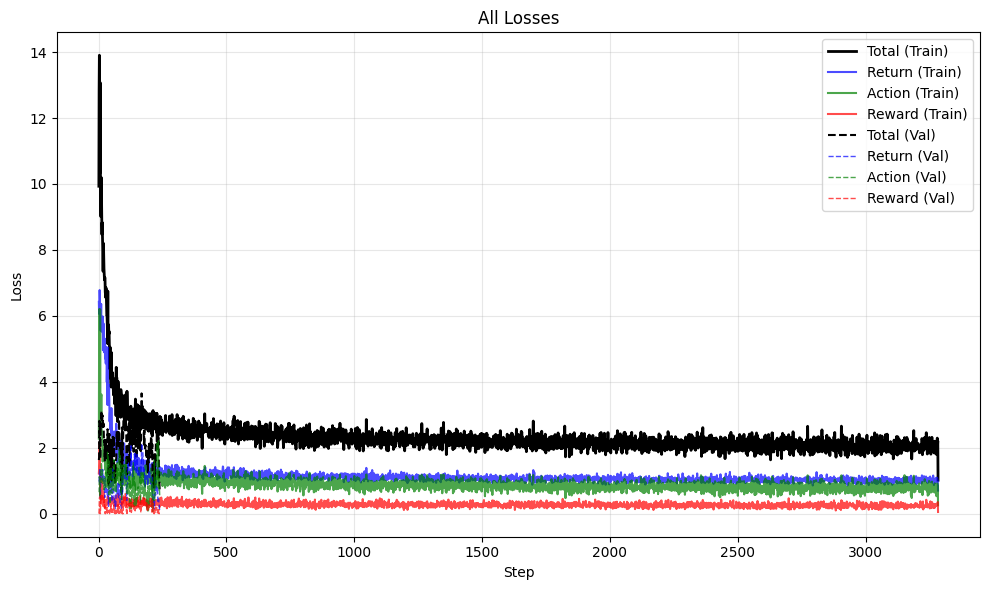

In [8]:
from mgdt_model_stats import plot_losses
plot_losses(train_stats, val_stats)

In [9]:
train_stats[:10]

[{'step': 1,
  'loss': 9.931851387023926,
  'loss_return': 6.424662113189697,
  'loss_action': 2.2825613021850586,
  'loss_reward': 1.2246272563934326,
  'ema_loss': 9.931851387023926,
  'grad_norm': 0.9999999265668843,
  'return_acc': 0.03125,
  'action_acc': 0.4375,
  'reward_acc': 0.8984375},
 {'step': 2,
  'loss': 12.832493782043457,
  'loss_return': 6.060164451599121,
  'loss_action': 5.369910717010498,
  'loss_reward': 1.402419090270996,
  'ema_loss': 9.989864234924317,
  'grad_norm': 0.9999999736541048,
  'return_acc': 0.0859375,
  'action_acc': 0.2578125,
  'reward_acc': 0.9140625},
 {'step': 3,
  'loss': 13.903130531311035,
  'loss_return': 6.1616315841674805,
  'loss_action': 6.209132194519043,
  'loss_reward': 1.5323665142059326,
  'ema_loss': 10.06812956085205,
  'grad_norm': 1.0000000115501229,
  'return_acc': 0.140625,
  'action_acc': 0.2578125,
  'reward_acc': 0.9140625},
 {'step': 4,
  'loss': 11.559610366821289,
  'loss_return': 6.783844947814941,
  'loss_action': 2.60

In [10]:
val_stats[:10]

[{'step': 1,
  'loss': 1.6299794912338257,
  'loss_return': 0.9719130396842957,
  'loss_action': 0.6522763967514038,
  'loss_reward': 0.005790136754512787,
  'return_acc': 0.75,
  'action_acc': 0.71875,
  'reward_acc': 1.0},
 {'step': 2,
  'loss': 1.7132394313812256,
  'loss_return': 0.9700918793678284,
  'loss_action': 0.6537904739379883,
  'loss_reward': 0.0893571525812149,
  'return_acc': 0.75,
  'action_acc': 0.796875,
  'reward_acc': 0.953125},
 {'step': 3,
  'loss': 2.8180091381073,
  'loss_return': 1.2249537706375122,
  'loss_action': 1.1313462257385254,
  'loss_reward': 0.46170929074287415,
  'return_acc': 0.75,
  'action_acc': 0.7109375,
  'reward_acc': 0.7734375},
 {'step': 4,
  'loss': 2.77662992477417,
  'loss_return': 1.334818959236145,
  'loss_action': 0.9352480173110962,
  'loss_reward': 0.5065628290176392,
  'return_acc': 0.75,
  'action_acc': 0.7265625,
  'reward_acc': 0.734375},
 {'step': 5,
  'loss': 2.318160057067871,
  'loss_return': 1.294865369796753,
  'loss_acti

In [1]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6}")

NameError: name 'model' is not defined